In [11]:
import pandas as pd
import glob
import cPickle as pickle
from scipy import signal
import os
import xlrd
import unicodedata
import time
import seaborn as sns
sns.set_style("whitegrid")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [12]:
# Import participants data
f = glob.glob('./Subjects data form.xls')
xl = pd.ExcelFile(f[0])
subjects_data = xl.parse(xl.sheet_names[0])
subjects_data = subjects_data.append(xl.parse(xl.sheet_names[1]))
subjects_data = subjects_data.append(xl.parse(xl.sheet_names[2]))
subjects_data = subjects_data.set_index(['ID'])
subjects_data = subjects_data.drop('Notes', axis=1)
#subjects_data = subjects_data.dropna()

def remove_accents(input_str):
    nkfd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nkfd_form.encode('ASCII', 'ignore')
    return only_ascii

def get_excercises_description(sheet):
    d = {}
    for i in range(sheet.nrows):
         row = sheet.row_values(i)
         for j in range(len(row)):
              if 'DATOS EJERCICIO' in row[j]:
                    id = int(row[j].split(' ')[-1])
                    i = i + 1
                    next_row = sheet.row_values(i)
                    descr = next_row[1]
                    #d[id] = descr.encode('ascii', 'ignore')
                    d[id] = remove_accents(descr)
    return d

# Drop empty lines
subjects_data = subjects_data.dropna()

# Remove non ASCII characters
subjects_data['Name'] = [remove_accents(x) for x in subjects_data['Name']]
subjects_data['Surname'] = [remove_accents(x) for x in subjects_data['Surname']]
subjects_data.head()

Date      Name        Surname             Birthday  \
ID                                                                       
S01  2015-03-11 00:00:00   Barbara       Cascardo  1989-04-27 00:00:00   
S02  2015-03-17 00:00:00   Gerardo          Avila  1977-05-02 00:00:00   
S03  2015-03-18 00:00:00  Fernando       Trincado  1983-12-01 00:00:00   
S04  2015-03-24 00:00:00     Diego        Serrano  1992-07-29 00:00:00   
S05  2015-04-29 00:00:00     Julio  Gomez Soriano  1983-01-29 00:00:00   

          Age  TA MT  I H1.1  I H1.2 I H 1.3  I CT          ...           \
ID                                                          ...            
S01  25.88767    8.0    17.5    17.5    17.5   6.4          ...            
S02  37.89863   32.0    60.0    60.0      60  25.6          ...            
S03  31.31507    6.0    12.0     9.0     7.5   4.8          ...            
S04  22.66575   15.5     5.5     5.5     5.5  12.4          ...            
S05  32.26849   17.0    12.0    12.0      12  13.6          ...            

    I H 2.1 I H2.2 I CT 2      Test 2  I cycling 2  Bike speed 2  \
ID                                                                 
S01    20.0   20.0  21.60  ES Cycling          6.0            42   
S02    33.0   35.0  28.00  ES Cycling         12.0            42   
S03     8.5    9.0   3.60     Cycling          3.5            42   
S04     5.5    6.2  10.64     Cycling          5.0            42   
S05    12.0   10.0   5.60  ES Cycling          9.0            42   

     Bike brake 2 Discomfort H 2  Discomfort CT 2  Discomfort Cycling 2  
ID                                                                       
S01             8              3                3                     0  
S02             8              5                4                     3  
S03             8              2                6                     4  
S04             8              0                1                     0  
S05             8              3                4                     0  

[5 rows x 30 columns]

In [13]:
# Filter CT experiments
df = pd.read_csv('all_pkl_paths.csv')
dfall = df[df.Experiment=='ct']
dfall.head()

CT         H         M                                     filename  UID  \
0   75  0.827365  0.013319  ./S01/ct 1.1/15-03-11-10-54-001-H_on_CT.pkl  S01   
1  100  1.199134  0.013854  ./S01/ct 1.1/15-03-11-10-54-002-H_on_CT.pkl  S01   
2  100  1.240342  0.027640  ./S01/ct 1.1/15-03-11-10-54-003-H_on_CT.pkl  S01   
3  100  1.097617  0.019150  ./S01/ct 1.1/15-03-11-10-54-004-H_on_CT.pkl  S01   
4    0  0.878786  0.016717  ./S01/ct 1.1/15-03-11-10-54-005-H_on_CT.pkl  S01   

  Experiment  Session  
0         ct      1.1  
1         ct      1.1  
2         ct      1.1  
3         ct      1.1  
4         ct      1.1

(0.075575647897269907, -0.081920033343152718)

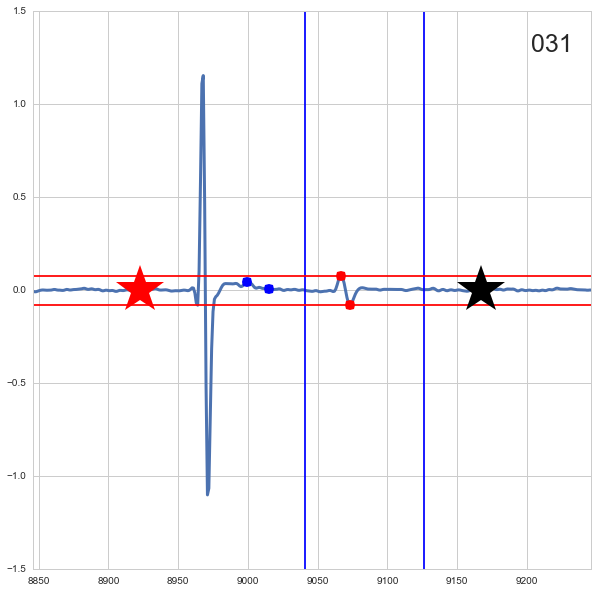

In [14]:
def openpkl(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    data['filename'] = file
    return (data)

# read emg
def get_emg(file):
    data = openpkl(file)
    return data['emg']

def get_emg_h(emg):
    return emg[0]

def get_emg_t(emg):
    return emg[2]

def butter_bandstop(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandstop')
    return b, a

def butter_bandstop_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def remove_pln(y, fsamp):
    """
    Removes Power Line Noise
    """
    for i in range(1, 2):
         fnotch = 50*i
         y = butter_bandstop_filter(y, fnotch-1, fnotch+1, fsamp, 4)
    return y

def filter_only(emg, freq):
    """
    Filter functions
    filter Butter HP 20 + rect + LP 400
    """
    #return emg - np.mean(emg)

    # Filter between 20 - 400 Hz
    Nyq = freq / 2.0  # Nyquist
    N = 2  # filter order
    Wlow = 20 / Nyq  # Cut-off 1
    Whigh = 450 / Nyq # Cut-off 2
    b, a = signal.butter(N, [Wlow, Whigh], btype='bandpass')
    y = signal.filtfilt(b, a, emg)  # Apply filter

    # Remove Power line Noise
    y = remove_pln(y, freq)

    # Demean signal
    y = y - np.mean(y)
    return y

def p2p(s):
    return max(s) - min(s)
    
def calculate_bemg(t_x, emg):
    # Calculating bEMG values
    bEMG_length = 52
    b_start = t_x - bEMG_length - 160
    b_end = t_x - 160

    bemg_sol = np.mean(abs(emg[0, b_start:b_end]))
    bemg_ta = np.mean(abs(emg[1, b_start:b_end]))

    bemg = {
        "bemg_sol": bemg_sol,
        "bemg_ta": bemg_ta,
    }

    return bemg

def find_trigx(emg):
    trig, = np.where(emg > 3)
    if len(trig) > 0:
        return trig[0]
    else:
        print("trig NOT found :(")
        return -1

def find_h(emg):
        """
        Calculates S, M, H
        """
        m_win_start = 20
        m_win_size = 30
        h_win_start = 75
        h_win_size = 85
        trigger_channel = 2
        
        t_x = find_trigx(emg[trigger_channel])
        if t_x < 0:
            # no valid trigger detected
            print('Unable to find H trigger')
            return (), (), ()
        t_w = (t_x, t_x + 10)
        
        start_m = t_x + m_win_start
        stop_m = start_m + m_win_size
        
        start_h = t_x + h_win_start
        stop_h = start_h + h_win_size
    
        indexes = [t_w, (start_m, stop_m), (start_h, stop_h)]
        #  P2P evaluation
        values = [0, p2p(emg[0][start_m:stop_m]), p2p(emg[0][start_h:stop_h])]

        bemg = calculate_bemg(t_x, emg)

        return values, indexes, bemg

def process_emg(fname):
    emg = get_emg(fname)
    h = get_emg_h(emg)
    t = get_emg_t(emg)
    femg = 2500.0
    # filter H
    emg[0] = filter_only(emg[0], femg)
    values, indexes, bemg = find_h(emg)
    return emg, indexes

def plot_h(emg, indexes, ax, tid, is_outlier=False, is_num_outlier=False, is_num_outlier_M=False):
    start_h = indexes[2][0]
    stop_h = indexes[2][1]
    start_m = indexes[1][0]
    stop_m = indexes[1][1]
    
    h = emg[0]
    ax.plot(h, linewidth=3, label=tid)
    ax.axvline(start_h)
    ax.axvline(stop_h)
    ax.set_xlim((indexes[0][0]-120, stop_h+120))
    
    xmax = argmax(h[start_h:stop_h]) + start_h
    ymax = h[xmax]
    xmin = argmin(h[start_h:stop_h]) + start_h
    ymin = h[xmin]

    xmax_m = argmax(h[start_m:stop_m]) + start_m
    ymax_m = h[xmax_m]
    xmin_m = argmin(h[start_m:stop_m]) + start_m
    ymin_m = h[xmin_m]

    ax.plot([xmax, xmin], [h[xmax], h[xmin]], marker='o', linestyle='', ms=10, color='red')
    ax.plot([xmax_m, xmin_m], [h[xmax_m], h[xmin_m]], marker='o', linestyle='', ms=10, color='blue')
    
    ax.axhline(h[xmax], color='red')
    ax.axhline(h[xmin], color='red')
    
    if is_outlier:
        ax.set_axis_bgcolor("lightgray")
    if is_num_outlier:
        ax.plot(xmax + 100, 0, marker='*', ms=50, color='black')
    if is_num_outlier_M:
        ax.plot(xmin - 150, 0, marker='*', ms=50, color='red')
    
    leg = ax.legend(loc=0,prop={'size':25})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(0)
    return ymax, ymin
    

fname = "./I10/ct 2.2/15-05-13-18-22-031-H_on_CT.pkl"
emg, indexes = process_emg(fname)

fig, ax = subplots(1,1, figsize=(10, 10))
plot_h(emg, indexes, ax, fname.split('-')[-2], False, True, True)

In [15]:
# NUMERICALLY IDENTIFY OUTLIERS

df = dfall.copy()
dfg = df.groupby(['UID', 'Experiment', 'CT', 'Session'])

df['NumOutlier'] = dfg.H.transform(lambda x: abs(x-x.mean())>1.96*x.std())

dfg = df.groupby(['UID', 'Experiment', 'Session'])
df['NumOutlier_M'] = dfg.M.transform(lambda x: abs(x-x.mean())>1.96*x.std())
dfall = df

In [16]:
# Set Test ID (TID)
def set_tid(row):
    fname = row.filename
    tid = fname.split('-')[-2]
    return tid

df = dfall.copy()
df['TID'] = df.apply(set_tid, axis=1)

dfall = df
dfall.head()

CT         H         M                                     filename  UID  \
0   75  0.827365  0.013319  ./S01/ct 1.1/15-03-11-10-54-001-H_on_CT.pkl  S01   
1  100  1.199134  0.013854  ./S01/ct 1.1/15-03-11-10-54-002-H_on_CT.pkl  S01   
2  100  1.240342  0.027640  ./S01/ct 1.1/15-03-11-10-54-003-H_on_CT.pkl  S01   
3  100  1.097617  0.019150  ./S01/ct 1.1/15-03-11-10-54-004-H_on_CT.pkl  S01   
4    0  0.878786  0.016717  ./S01/ct 1.1/15-03-11-10-54-005-H_on_CT.pkl  S01   

  Experiment  Session  NumOutlier  NumOutlier_M  TID  
0         ct      1.1           0             0  001  
1         ct      1.1           0             0  002  
2         ct      1.1           0             1  003  
3         ct      1.1           0             0  004  
4         ct      1.1           0             0  005

In [22]:
def get_num(filename):
    return filename.split('-')[-2]

#MANUALLY SELECTED OUTLIERS
outliers = [('S14', 1.2, '001'), ('S13', 1.3, '037'), ('S13', 1.3, '052'),
            ('S13', 1.3, '054'), ('S13', 1.3, '055'), ('S13', 1.3, '057'), ('S13', 1.3, '058'),  
            ('S13', 1.3, '060'), ('S13', 1.3, '062'),
            ('S13', 1.1, '028'),
            ('S12', 1.3, '051'),
            ('S10', 2.2, '048'), ('S10', 2.2, '017'),
            ('S10', 2.1, '024'),
            ('S10', 1.3, '034'),  ('S10', 1.3, '036'),  ('S10', 1.3, '056'),
            ('S10', 1.2, '051'), ('S10', 1.2, '066'), ('S10', 1.2, '049'),
            ('S09', 2.2, '044'),
            ('S09', 2.1, '004'), ('S09', 2.1, '005'), 
            ('S08', 2.1, '044'),
            ('S08', 1.3, '073'), ('S08', 1.3, '056'), ('S08', 1.3, '020'), 
            ('S08', 1.2, '070'), ('S08', 1.2, '170'), ('S08', 1.2, '120'),
            ('S08', 1.1, '068'),
            ('S07', 2.2, '054'),
            ('S07', 2.1, '017'), ('S07', 2.1, '020'), ('S07', 2.1, '075'), ('S07', 2.1, '067'),
            ('S07', 1.3, '063'), ('S07', 1.3, '035'), ('S07', 1.3, '055'), ('S07', 1.3, '067'),
            ('S07', 1.2, '001'), ('S07', 1.2, '038'),
            ('S06', 2.2, '001'),
            ('S06', 2.1, '075'),
            ('S06', 1.3, '069'), ('S06', 1.3, '070'), ('S06', 1.3, '065'), ('S06', 1.3, '029'), ('S06', 1.3, '031'),
            ('S06', 1.2, '029'), ('S06', 1.2, '028'), ('S06', 1.2, '024'),
            ('S05', 1.3, '072'), ('S05', 1.3, '050'), 
            ('S05', 2.1, '037'),
            ('S05', 2.2, '033'),
            ('S04', 2.2, '073'), ('S04', 2.2, '068'), ('S04', 2.2, '040'),
            ('S04', 1.3, '063'), ('S04', 1.3, '050'), ('S04', 1.3, '011'), ('S04', 1.3, '019'), 
            ('S04', 1.2, '048'), ('S04', 1.2, '022'), 
            ('S04', 1.2, '057'), ('S04', 1.2, '058'), ('S04', 1.2, '059'), ('S04', 1.2, '060'),('S04', 1.2, '061'),
            ('S04', 1.2, '062'), ('S04', 1.2, '063'), ('S04', 1.2, '064'), ('S04', 1.2, '065'), ('S04', 1.2, '066'),
            ('S04', 1.2, '067'), ('S04', 1.2, '068'), ('S04', 1.2, '069'), ('S04', 1.2, '070'), ('S04', 1.2, '071'),
            ('S04', 1.1, '039'), ('S04', 1.1, '025'), ('S04', 1.1, '040'), ('S04', 1.1, '049'), ('S04', 1.1, '058'),
            ('S04', 1.1, '003'), ('S04', 1.1, '010'), ('S04', 1.1, '051'), 
            ('S03', 1.1, '068'),
            ('S02', 2.2, '001'),
            ('S01', 1.3, '004'), ('S01', 1.3, '038'),
            ('I10', 1.3, '075'),  ('I10', 1.3, '073'),  ('I10', 1.3, '057'),
            ('I10', 1.2, '035'),
            ('I10', 1.1, '033'),
            ('I09', 2.2, '038'), ('I09', 2.2, '053'),
            ('I09', 2.1, '039'),
            ('I09', 1.2, '055'), ('I09', 1.2, '056'), ('I09', 1.2, '067'), ('I09', 1.2, '072'), 
            ('I06', 2.2, '073'),  
            ('I06', 2.1, '007'), ('I06', 2.1, '006'), ('I06', 2.1, '014'), ('I06', 2.1, '008'),
            ('I06', 2.1, '031'), ('I06', 2.1, '039'), ('I06', 2.1, '058'), ('I06', 2.1, '044'),
            ('I06', 2.1, '062'), ('I06', 2.1, '060'), ('I06', 2.1, '035'), ('I06', 2.1, '065'),
            ('I06', 2.1, '061'), 
            ('I06', 1.3, '047'), ('I06', 1.3, '050'), ('I06', 1.3, '054'), ('I06', 1.3, '009'), 
            ('I06', 1.2, '002'),
            ('I05', 2.2, '040'),
            ('I05', 2.1, '058'), ('I05', 2.1, '055'), ('I05', 2.1, '064'), ('I05', 2.1, '031'), ('I05', 2.1, '014'),
            ('I05', 2.1, '028'), ('I06', 2.1, '037'), ('I06', 2.1, '065'), ('I06', 2.1, '035'), 
            ('I05', 1.3, '030'), ('I05', 1.3, '075'), ('I05', 1.3, '030'), ('I05', 1.3, '003'),
            ('I05', 1.3, '175'), ('I05', 1.3, '147'), ('I05', 1.3, '123'), ('I05', 1.3, '148'), ('I05', 1.3, '130'),
            ('I05', 1.3, '132'), ('I05', 1.3, '150'), 
            ('I05', 1.2, '073'), ('I05', 1.2, '049'),  ('I05', 1.2, '024'), ('I05', 1.2, '021'), ('I05', 1.2, '022'),
            ('I05', 1.2, '022'), ('I05', 1.2, '037'), ('I05', 1.2, '006'), ('I05', 1.2, '017'), 
            ('I05', 1.1, '009'), ('I05', 1.1, '023'), ('I05', 1.1, '026'), ('I05', 1.1, '028'),
            ('I05', 1.1, '004'), ('I05', 1.1, '036'), ('I05', 1.1, '065'), ('I05', 1.1, '062'), ('I05', 1.1, '038'),
            ('I05', 1.1, '003'), ('I05', 1.1, '141'), ('I05', 1.1, '164'), ('I05', 1.1, '109'), ('I05', 1.1, '032'),
            ('I05', 1.1, '130'), ('I05', 1.1, '136'), ('I05', 1.1, '139'), ('I05', 1.1, '165'), 
            ('I05', 1.1, '022'), ('I05', 1.1, '025'), ('I05', 1.1, '029'), ('I05', 1.1, '128'), ('I05', 1.1, '138'),
            ('I05', 1.1, '162'), ('I05', 1.1, '024'), ('I05', 1.1, '135'), ('I05', 1.1, '137'), 
            ('I04', 2.2, '012'), ('I04', 2.2, '004'), ('I05', 1.1, '027'), ('I05', 1.1, '031'), ('I05', 1.1, '002'), 
            ('I03', 1.3, '007'), ('I03', 1.3, '039'), ('I03', 1.3, '044'), ('I03', 1.3, '033'),  
            ('I02', 1.3, '063'), ('I02', 1.3, '008'), ('I02', 1.3, '043'),   
            ('I02', 2.1, '054'), ('I02', 2.1, '056'), ('I02', 2.1, '053'), ('I02', 2.1, '073'), 
            ('C01', 2.1, '015'), ('C01', 2.1, '022'), ('C01', 2.1, '049'), ('C01', 2.1, '062'),
            ('C01', 2.1, '053'), ('C01', 2.1, '008'), 
           ] 

subjects_removed = ['S02', 'I09']

# Plot and save emg
def plot_emg(dfall, id='S01', session=1.1):
        colsname = [0, 25, 50, 75, 100]
        cols = len(colsname)
        rows = 0
        # Select UID 
        dfid = dfall[dfall.UID == id]
        # Select Session
        dfid = dfid[dfid.Session == session]
        # determine number of rows
        dfc = dfid.groupby('CT').count()
        rows = max(dfc.UID) # I can use any column here...
        # Generate figure
        fig, axs = subplots(rows, cols, figsize=(25, 50))
        row = 0
        ymax = []
        ymin = []
        for col in range(cols):
            # Select Session
            dsess = dfid[dfid.CT == colsname[col]] 
            row = 0
            for i, r in dsess.iterrows():
                fname = r.filename
                is_num_outlier = r.NumOutlier
                is_num_outlier_M = r.NumOutlier_M
                ax = axs[row][col]
                row +=1
                emg, indexes  = process_emg(fname)
                
                tid = r.TID
                
                # Check outlier
                if (id, session, tid) in outliers:
                    is_outlier = True
                else:
                    is_outlier = False
                        
                yM, ym = plot_h(emg, indexes, ax, tid, is_outlier, is_num_outlier, is_num_outlier_M)
                ymax += [yM]
                ymin += [ym]
                
        # scale Y in every subplot
        yMM = max(ymax)
        ymm = min(ymin)
        
        for col in range(cols):
            for row in range(rows):
                ax = axs[row][col]
                ax.set_ylim(ymm, yMM)
            
        # Save figure
        fig.savefig('Individual graphs/' + id + ' ' + str(session) +'.png', format='png', dpi=50)
        close()  # close figure
        print id + ' ' + str(session) + " generated"
    

all_ids = dfall.UID.unique()
all_sessions = dfall.Session.unique()


all_ids = [x for x in all_ids if x[0]=='S']
for id in all_ids:
    for session in all_sessions:
        plot_emg(dfall, id, session)

S01 1.1 generated
S01 1.2 generated
S01 1.3 generated
S01 2.1 generated
S01 2.2 generated
S02 1.1 generated
S02 1.2 generated
S02 1.3 generated
S02 2.1 generated
S02 2.2 generated
S03 1.1 generated
S03 1.2 generated
S03 1.3 generated
S03 2.1 generated
S03 2.2 generated
S04 1.1 generated
S04 1.2 generated
S04 1.3 generated
S04 2.1 generated
S04 2.2 generated
S05 1.1 generated
S05 1.2 generated
S05 1.3 generated
S05 2.1 generated
S05 2.2 generated
S06 1.1 generated
S06 1.2 generated
S06 1.3 generated
S06 2.1 generated
S06 2.2 generated
S07 1.1 generated
S07 1.2 generated
S07 1.3 generated
S07 2.1 generated
S07 2.2 generated
S08 1.1 generated
S08 1.2 generated
S08 1.3 generated
S08 2.1 generated
S08 2.2 generated
S09 1.1 generated
S09 1.2 generated
S09 1.3 generated
S09 2.1 generated
S09 2.2 generated
S10 1.1 generated
S10 1.2 generated
S10 1.3 generated
S10 2.1 generated
S10 2.2 generated
S11 1.1 generated
S11 1.2 generated
S11 1.3 generated
S11 2.1 generated
S11 2.2 generated
S12 1.1 ge

In [18]:
# Mark manually selected outliers
df = dfall.copy()
df['ManualOutlier'] = 0
for (uid, session, tid) in outliers:
    df.ix[(df.UID == uid) & (df.Session == session) & (df.TID == tid), 
          'ManualOutlier'] = 1
for uid in subjects_removed:
    df.ix[df.UID == uid, 'ManualOutlier'] = 1
df_out = df
df_out[df_out.ManualOutlier == 1].head()  

CT         H         M                                     filename  \
153   50  0.070427  0.017443  ./S01/ct 1.3/15-03-11-11-40-004-H_on_CT.pkl   
187   25  0.116601  0.024634  ./S01/ct 1.3/15-03-11-11-40-038-H_on_CT.pkl   
375  100  0.577673  0.132547  ./S02/ct 1.1/15-03-17-11-11-001-H_on_CT.pkl   
376  100  0.440153  0.128246  ./S02/ct 1.1/15-03-17-11-11-002-H_on_CT.pkl   
377   50  0.159210  0.104446  ./S02/ct 1.1/15-03-17-11-11-003-H_on_CT.pkl   

     UID Experiment  Session  NumOutlier  NumOutlier_M  TID  ManualOutlier  
153  S01         ct      1.3           1             0  004              1  
187  S01         ct      1.3           1             0  038              1  
375  S02         ct      1.1           1             0  001              1  
376  S02         ct      1.1           0             0  002              1  
377  S02         ct      1.1           0             0  003              1

In [19]:
# select all outliers
df = df_out.copy()
df['Outlier'] = 0
df.ix[df.ManualOutlier | df.NumOutlier, 'Outlier'] = 1
df_noout = df[df['Outlier'] == 0]
df_noout = df_noout.drop(['NumOutlier', 'NumOutlier_M', 'ManualOutlier', 'Outlier'], axis=1)
df_noout.head()

# select all outliers_M
df = df_out.copy()
df['Outlier'] = 0
df.ix[df.NumOutlier_M, 'Outlier'] = 1
df_noout_m = df[df['Outlier'] == 0]
df_noout_m = df_noout_m.drop(['NumOutlier', 'NumOutlier_M', 'ManualOutlier', 'Outlier'], axis=1)
df_noout_m.head()

CT         H         M                                     filename  UID  \
2  100  1.240342  0.027640  ./S01/ct 1.1/15-03-11-10-54-003-H_on_CT.pkl  S01   
3  100  1.097617  0.019150  ./S01/ct 1.1/15-03-11-10-54-004-H_on_CT.pkl  S01   
4    0  0.878786  0.016717  ./S01/ct 1.1/15-03-11-10-54-005-H_on_CT.pkl  S01   
5  100  1.069179  0.021813  ./S01/ct 1.1/15-03-11-10-54-006-H_on_CT.pkl  S01   
6   25  0.795954  0.017183  ./S01/ct 1.1/15-03-11-10-54-007-H_on_CT.pkl  S01   

  Experiment  Session  TID  
2         ct      1.1  003  
3         ct      1.1  004  
4         ct      1.1  005  
5         ct      1.1  006  
6         ct      1.1  007

In [20]:
# Write data to Excel
writer = pd.ExcelWriter('all_data_noout.xls')

dfall.fillna(-9999).to_excel(writer, 'all')
df_noout.fillna(-9999).to_excel(writer, 'noout')
df_noout_m.fillna(-9999).to_excel(writer, 'noout_m')

writer.save()